# Introduction to Modern Mathematical Modeling
# Chapter 4; Principles of Mathematical Modeling

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, to_rgba
import warnings
warnings.filterwarnings("ignore")

In [32]:
styledict = {'xtick.labelsize':25,
             'xtick.major.size':9,
             'xtick.major.width':1,
             'ytick.labelsize':25,
             'ytick.major.size':9,
             'ytick.major.width':1,
             'legend.framealpha':0.0,
             'legend.fontsize':15,
             'axes.labelsize':20,
             'axes.titlesize':25,
             'axes.linewidth':2,
             'figure.figsize':(12,8),
             'savefig.format':'jpg'}
plt.rcParams.update(**styledict)

In [33]:
def new_col_map(colors):
    """
    This function creates a new color map from a list of colors given
    as a parameter. Recommended length of list of colors is at least 6.
    """
    first = np.repeat([to_rgba(colors[0])], 4, axis = 0)
    last = np.repeat([to_rgba(colors[-1])], 4, axis = 0)
    v = cm.get_cmap('viridis', 16*(len(colors)-2))
    newcolors = v(np.linspace(0, 1, 16*(len(colors)-2)))
    for (i, col) in enumerate(colors[1:-1]):
        newcolors[16*i : 16*(i+1), :] = to_rgba(col)
    return ListedColormap(np.append(np.append(first,newcolors, axis=0), last, axis=0))

In [34]:
m19 = pd.read_csv("tbol_snapshot.pbin4d-19.out-180-0.txt", sep='\s+', header=None)
mapmat = np.array(m19.iloc[:,2]).reshape(720,360).T
# The '.T' is another way to transpose a numpy array.

In [35]:
lat1 = np.linspace(-89.75, 89.75, 360)
lon1 = np.linspace(-189.75, 169.75, 720)
# Arrays representing latitude and longitude of the moon.

colors = ['skyblue', 'green', 'blue', 'yellow', 'orange', 'pink', 'red', 'maroon', 'purple', 'black']
myColMap = new_col_map(colors)
# A list of colors and new_col_map() to create a matplotlib color map.

mapmat[mapmat == mapmat.max()] = 400
mapmat[mapmat == mapmat.min()] = 0
# This is called logical indexing. It allows you to index into parts
# of an array where the given condition in the brackets is true, as
# opposed to numerical where it goes by index. Also, all numpy arrays
# have a max() and min() member that returns the greatest and smallest
# element in the array respectively.


clev = np.linspace(mapmat.min(), mapmat.max(), 60)
# The number of 'level curves' in the filled contour plot below.

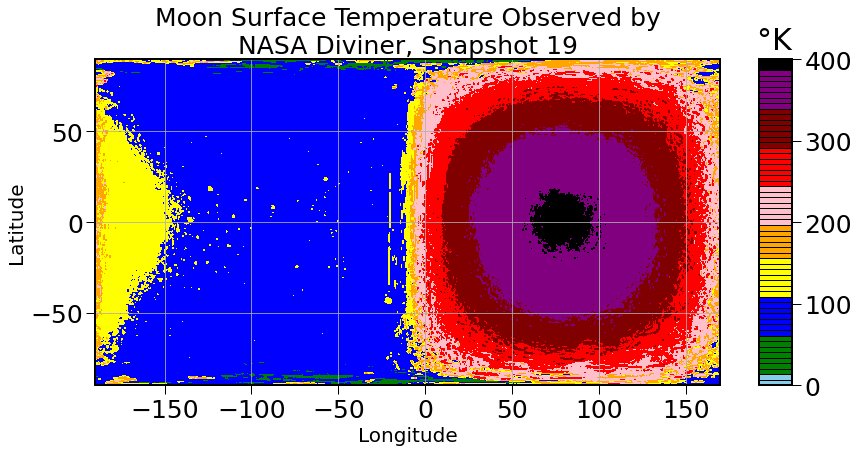

In [36]:
plt.figure(figsize=(14,6))
contf = plt.contourf(lon1, lat1, mapmat, clev, cmap=myColMap)
# plt.contourf allows you to create a filled (color-coded) contour plot.

colbar = plt.colorbar(contf, drawedges=True, ticks=[0, 100, 200, 300, 400],
                      aspect = 10)
# plt.colorbar uses an existing contourf handle (like contf) to create
# a colorbar corresponding to the contourf.

plt.title("Moon Surface Temperature Observed by\n"
          "NASA Diviner, Snapshot 19")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.text(190, 95, "$\degree$K", size=30)
# plt.text allows you to put text in your plot at the given coordinates,
# here its (190, 95). The coordinates used correspond to those defined
# by the x and y axes of the plot.

plt.grid();
# plt.grid adds gridlines to the plot anchored at the same location as
# the ticks on the axes.

plt.savefig("CH4;DivinerSurfaceTempMoon.jpg", bbox_inches='tight');
# plt.savefig lets you save the figure created with the given
# filename.

In [37]:
equ = np.where((lat1 < .5) & (lat1 > -.5))[0]
equatorial = mapmat[equ[0]]
# np.where accepts a logical expression on an array and returns an array
# of indices where that logical expression is true. That array can be
# used as non-consecutive indices in another array, similar to logical
# indexing.

merid = np.where((lon1 < 90.5) & (lon1 > 89.5))[0]
meridion = mapmat[:, merid[0]]


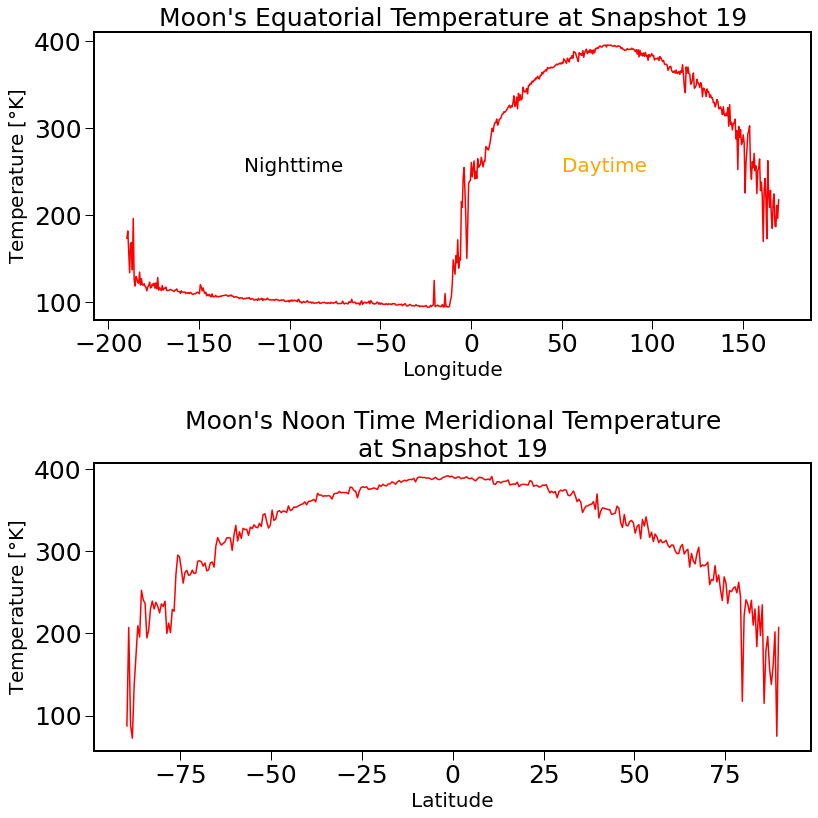

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,12))
# This is an alternate way to create plots. ax is an array of plot
# handles of shape (2, 1), and fig is the handle for the whole figure.

ax[0].plot(lon1, equatorial, 'r-')
ax[0].text(-125, 250, "Nighttime", size=20)
ax[0].text(50, 250, "Daytime", size=20, color='orange')
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Temperature [$\degree$K]")
ax[0].set_title("Moon's Equatorial Temperature at Snapshot 19");
# As ax is an array, ax[0] refers to it's first plot and ax[1] refers
# to it's second. The previously used member functions can be applied
# to each plot separately, as can be seen above and below.

ax[1].plot(lat1, meridion, 'r-')
ax[1].set_xlabel("Latitude")
ax[1].set_ylabel("Temperature [$\degree$K]")
ax[1].set_title("Moon's Noon Time Meridional Temperature\n"
                "at Snapshot 19");

fig.tight_layout(pad=3)
# fig.tight_layout sets the spacing between plots in the figure.

fig.savefig("CH4;MoonEquatorialMeridionalTemp.jpg")
# fig.savefig does the same as plt.savefig, but specifies that fig is the
# figure to be saved.

In [39]:
bt = np.array(m19.iloc[129600:].astype(np.float))
type(bt)
aw = np.cos(bt[:,1]*np.pi/180)
wbt = bt[:,2]*aw
bta = np.sum(wbt)/np.sum(aw)
print(f"Average temperature of bright side of moon: {bta:.4f} degrees Kelvin")

dt=np.array(m19.iloc[:129600].astype(np.float))
aw=np.cos(dt[:,1]*np.pi/180)
wdt=dt[:,2]*aw
dta=np.sum(wdt)/np.sum(aw)
print(f"Average temperature of dark side of moon: {dta:.4f} degrees Kelvin")
# The above scripts calculate the approximate average temperatures on
# each side of the law.

Average temperature of bright side of moon: 302.7653 degrees Kelvin
Average temperature of dark side of moon: 99.5569 degrees Kelvin


In [40]:
from scipy import optimize as opt

def ebm_maker(a, s, l, e, si, ka, t0, he):
    """
    This function accept a set of Energy Balance Model parameters
    and returns a lambda function with those parameters as a function
    of t.
    """
    return lambda t: (1-a)*s*np.cos(l) - e*si*(t**4) - ka*(t - t0)/he

### Root-finding and EBM.

In [41]:
lat = 0*(np.pi/180)
# Conversion from degrees to radians.

sigma = 5.670367e-8
alpha = 0.12
S = 1368
ep = 0.98
k = 7.4e-4
h = 0.4
T0 = 260
# These are the other parameters of the fEBM.

fEBM = ebm_maker(alpha, S, lat, ep, sigma, k, T0, h)
# This creates a lambda function can be used with root-finding
# techniques below.

res = opt.root(fEBM, x0=400)
x_root = res['x'][0]
print(f"Root of fEBM: x = {x_root}")
# opt.root takes a function and a starting guess and uses
# Newton's method to find a root of the function near a
# starting guess. The function itself returns a dictionary
# and the x value of that is what we want.

Root of fEBM: x = 383.629726096338


In [42]:
lat1 = 60*np.pi/180
fEBM2 = ebm_maker(alpha, S, lat1, ep, sigma, k, T0, h)
# Same fEBM but at a different latitude.

res2 = opt.root(fEBM2, x0=400)
x_root_2 = res2['x'][0]
print(f"Root of fEBM2: x = {x_root_2}")

Root of fEBM2: x = 322.5926686260332


In [43]:
S1 = 0
h1 = 0.02

fEBM3 = ebm_maker(alpha, S1, lat1, ep, sigma, k, T0, h1)
# Again with different parameters.

res3 = opt.root(fEBM3, x0 = 200)
x_root_3 = res3['x'][0]
print(f"Root of fEBM3: x = {x_root_3}")

Root of fEBM3: x = 101.375636319434


### Nonlinear Albedo Feedback

In [44]:
albedoF = lambda t: 0.5 - 0.2 *np.tanh((t-265)/10)
t = np.linspace(200, 350, 1001)
# albedoF lambda function of t. np.tanh is the hyperbolic
# tangent function.

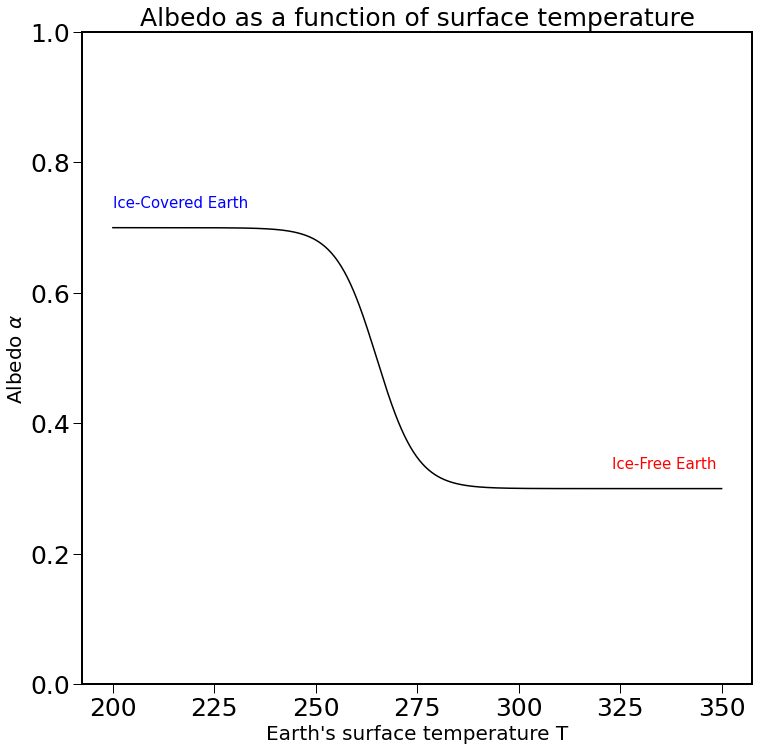

In [45]:
plt.figure(figsize=(12,12))
plt.plot(t, albedoF(t), 'k-')
plt.ylim(0,1)
# plt.ylim lets you set the bounds on the y axis manually. An x
# counterpart also exists: plt.xlim.

plt.xlabel("Earth's surface temperature T")
plt.ylabel(r"Albedo $\alpha$");
plt.title("Albedo as a function of surface temperature")
plt.text(200, 0.73, "Ice-Covered Earth", color = 'blue', size = 15)
plt.text(323, 0.33, "Ice-Free Earth", color = 'red', size = 15)

plt.savefig("CH4;AlbedoVsSurfaceTemp.jpg")

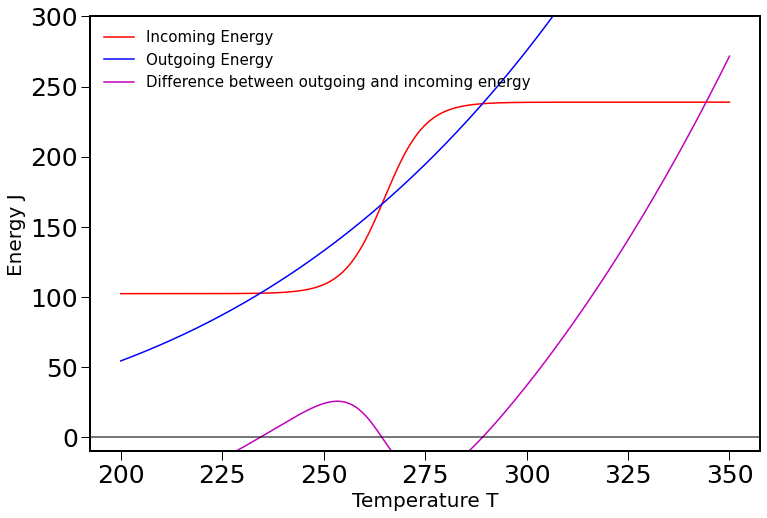

In [46]:
S = 1365
ep = 0.6
sg = 5.670373e-8
y1 = (1-albedoF(t))*(S/4.0)
y2 = ep*sg*(t**4)

plt.figure(figsize=(12,8))
plt.plot(t, y1, 'r-', label="Incoming Energy")
plt.plot(t, y2, 'b-', label="Outgoing Energy")
plt.plot(t, y2 - y1, 'm-',
         label="Difference between outgoing and incoming energy")
# Recall that the difference 'y2 - y1' is vectorized.

plt.axhline(y=0, alpha=.7, color='black')
# plt.axhline creates a horizontal line that spans the plot at
# the specified y value. y=0 means its the x-axis.

plt.legend(loc='best')
# legend places a legend for curves with labels in the plot.
# 'best' find the best location for it and places it there.

plt.ylim(-10,300)
plt.xlabel("Temperature T")
plt.ylabel("Energy J");

plt.savefig("CH4;EnergyBalancePlot.jpg")

In [47]:
f = lambda s: ep*sg*s**4 - (1 - albedoF(s))*(S/4.0)

r1 = opt.bisect(f, 220, 240)
r2 = opt.bisect(f, 260, 275)
r3 = opt.bisect(f, 275, 295)
print(f"Root 1: {r1:3.3f}, root 2: {r2:3.3f}, root 3: {r3:3.3f}")
# opt.bisect uses a bisection method, so unlike opt.root you must
# provide an interval in which a root might exist. The roots are
# for the difference 'y2 - y1' above.

Root 1: 234.382, root 2: 264.338, root 3: 289.140
